In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette="colorblind", style="darkgrid")

N = 100
lambd = 0.1 #min^-1
t_trajet = 5 #min
p_panne = 0.01
p_vide = 0.1
t_intervention = 30 #min
t_recharge = 240 #min
t_reparation = 720 #min



Student: Luiz Augusto Facury de Souza

1) In this project, I will use the colony process in order to model the system. To define the process, I used 4 colonies:

1 - Trotinette available

2 - Trotinette in use

3 - Trotinette in maintenance

4 - Trotinette recharging

To connect the colonies, I used the following conections:

1 -> 2 : The user takes a trotinette, rate $\frac{1}{\lambda}$

2 -> 1 : The trotinette returns to the available state, rate $\frac{1}{t_{trajet}}$

2 -> 3 : The trotinette breaks down, rate $\frac{1}{t_{panne}}$

2 -> 4 : The trotinette needs to be recharged, rate $\frac{1}{t_{recharge}}$

3 -> 1 : The trotinette is repaired, rate $\frac{1}{t_{reparation}}$

4 -> 1 : The trotinette is recharged, rate $\frac{1}{t_{recharge}}$

Using this process, we are able to simulate the system and obtainthe number of trotinettes present in each colony at each time, knowing that the time between events follows an exponential distribution with parameter depending on the system state.

Since we only allow individuals to transition one colony at a time, we have to obtain, for each defined time, the transition rates of each colony and draw a random number from the probabilities of each transition, choosing in each time which event will occur.

2) Knowing that the trotinette has a $p_{vide}$ probability of having to be recharged and a $p_{panne}$ probability of breaking down, we can calculate the probabilities of departure from each colony. Since only the Colony 2 has more than one possible transition, we obtain the following probabilities:

$P(2->1) = 1 - p_{vide} - p_{panne}$

$P(2->3) = p_{panne}$

$P(2->4) = p_{vide}$

The other colonies have only one possible transition, so the probability of transition is 1.

We already defined the $\lambda$ parameters for each colony, so we can multiply it by the probabilities of transition to obtain the final $\lambda_{jk}$ parameters for each colony. 

The final transition rates are given by $q(n, T_{jk}(n)) = \lambda_{jk} \times \phi_j (n_j), \phi(0) = 0$.

We define the parameter $\phi_j$ as the number of individuals in the colony $j$ at time $n_j$, except for the colony 1, in which it represents only an indicator function, since we can argue that the number of individuals that leave the colony 1 is not influenced by the number of individuals inside it.

Finally, we can calculate the time in which the next event will occur by applying an exponential function and normalize the transition rates to obtain the probabilities of each transition and draw a numbrer to determine which event will occur.









3) We can get the expression to the stationary distribution by using the following formula:

$\pi(n_1, n_2, n_3, n_4) =  G^{-1}\Pi_{j=1}^{4} \frac{\alpha_j^{n_j}}{\Pi_{m=1}^{n_j}\phi_j(m)} = G^{-1}\Pi_{j=1}^{4} \frac{\alpha_j^{n_j}}{\Pi_{m=1}^{n_j}m}$

To calculate the $\alpha_j$ parameters, we can use the following formula:

$\alpha_j = \frac{q(n, T_{jk}(n))}{\sum_{k=1}^{4} q(n, T_{jk}(n))} = \frac{\lambda_{jk} \times \phi_j (n_j)}{\sum_{k=1}^{4} \lambda_{jk} \times \phi_j (n_j)}$

4) Below is the code used to simulate the system during 100 hours

In [4]:
def construct_q(lambdas, state):
    q = lambdas.copy()
    # Multiply the lambdas by the number of individuals in each state, except for the first one
    for i in range (1, len(state)):
        q[i] = lambdas[i] * state[i]

    #Indicator function for the first state
    if state[0] == 0:
        q[0] = 0


    return q

def draw_and_update (q_normalized, state):
    # Draw the next state
    next = np.random.choice(len(q_normalized.flatten()), p=q_normalized.flatten())
    # Update the state

    i = (next // 4)  #Line index
    j = (next % 4)  #Column index

    state[i] -= 1
    state[j] += 1
    
    return state

def simulate (lambdas, init, T):
    state = init.copy()
    states = [state]
    times = [0]
    #Run the simulation until the time T
    while times[-1] < T:
        q = construct_q(lambdas, state)
        #Normalize the matrix in order to have a probability distribution
        q_normalized = q / np.sum(q)
        #Draw and update the next state
        draw_and_update(q_normalized, state)

        states.append(state.copy())
        times.append(times[-1] + np.random.exponential(1/np.sum(q)))
    return np.array(states), np.array(times)

In [5]:
probs = np.array([[0, 1, 0, 0],
                  [1-p_vide-p_panne, 0, p_panne, p_vide],
                  [1, 0, 0, 0],
                  [1, 0, 0, 0]])

rates = np.array([[0, lambd, 0, 0],
                  [1/t_trajet, 0 ,1/t_intervention, 1/t_intervention],
                  [1/t_reparation, 0, 0, 0],
                  [1/t_recharge, 0, 0, 0]])


lambdas = probs * rates

init = np.array([50, 45, 2, 3])


In [6]:
#Start the simulation
a, t = simulate(lambdas, init, 6000)

Text(0, 0.5, 'Number of trottinettes')

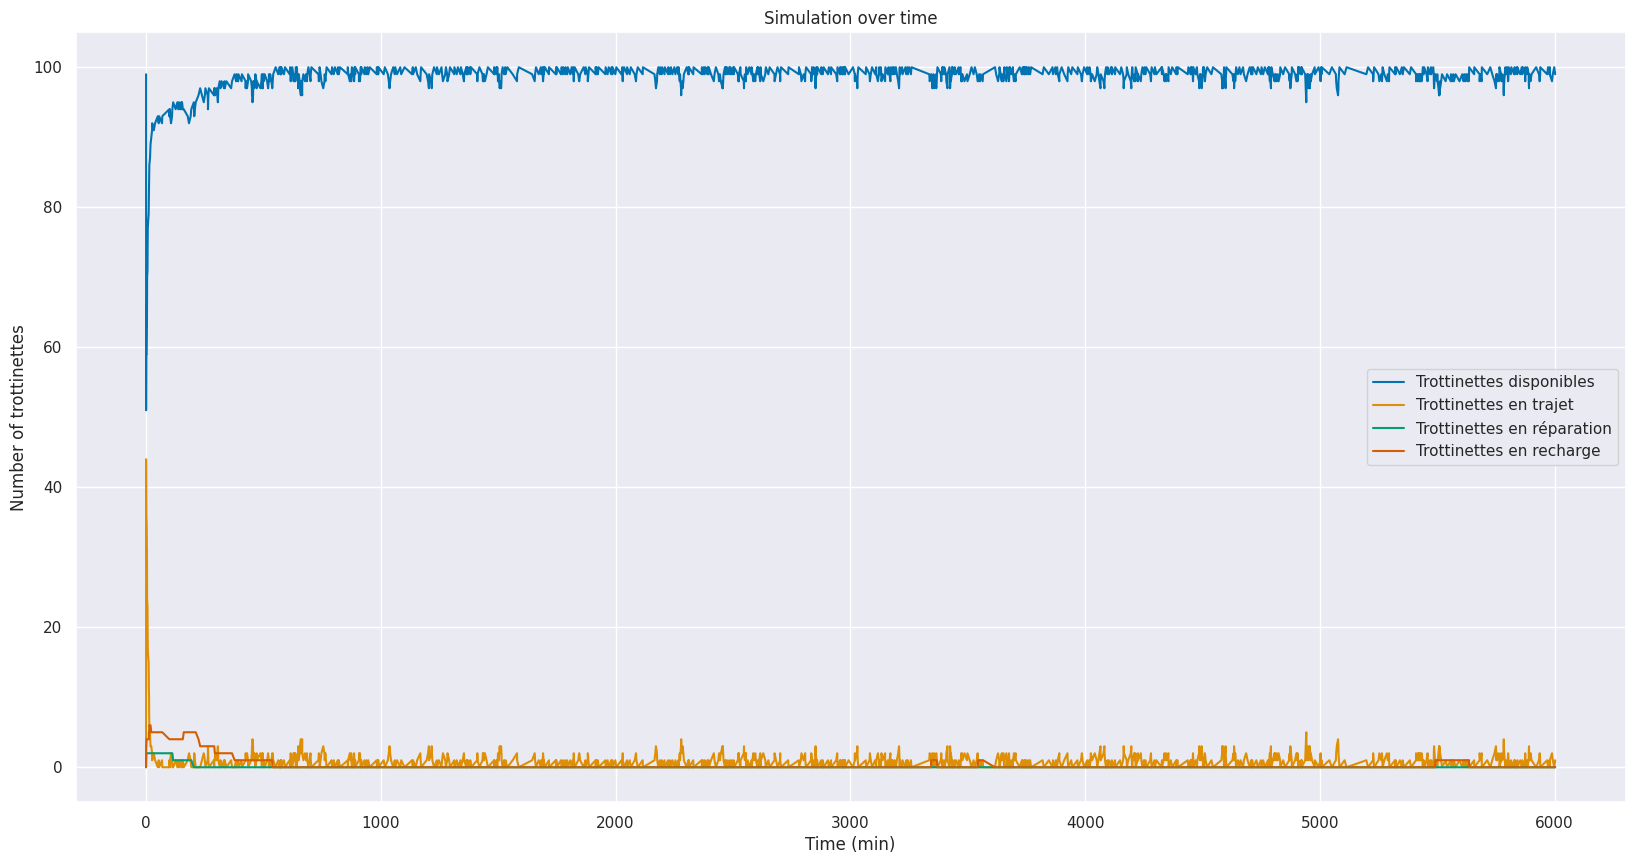

In [7]:
plt.figure(figsize=(20,10))
plt.plot(t, a[:,0])
plt.plot(t, a[:,1])
plt.plot(t, a[:,2])
plt.plot(t, a[:,3])
plt.legend(["Trottinettes disponibles", "Trottinettes en trajet", "Trottinettes en réparation", "Trottinettes en recharge"])
plt.title("Simulation over time")
plt.xlabel("Time (min)")
plt.ylabel("Number of trottinettes")

We can see that the number of individuals in colony 1 is much higher than the others, as it was already expected, since the final rate of individuals going from colony 2 to 1 is higher than the one going from 1 to 2, even though the initial rate of individuals going from 1 to 2 is higher than the one going from 2 to 1 (as there are more than 1 possible transition). It is also possible to see that the other 2 transitions do not change very often, as it was also expected, since the rate of individuals going from colony 2 to 3 and 4 is very low. Finally, if we had used the $\phi_1$ as the number of individuals in colony 1, instead of the indicator function, we could expect the number of individuals to be more balanced.

5) We can use the Monte Carlo method in order to estimate the stationnary probabilities. Therefore, we will run the simulation many times and calculate the average number of individuals in each colony. The results are shown below:

In [9]:
import tqdm
init = np.array([2, 0, 0, 0])
n = 100000
probs_mc = np.array([simulate(lambdas, init, 6000)[0][-1] for i in tqdm.tqdm(range(n))])
probs_mc = probs_mc*100/2
mean_probs = np.mean(probs_mc, axis=0)
std_probs = np.std(probs_mc, axis=0) 
print ("Proportion of time spent in each state :")
print (mean_probs)
print ("Std of the proportion of time spent in each state :")
print (std_probs)

100%|██████████| 100000/100000 [49:07<00:00, 33.93it/s]


Proportion of time spent in each state :
[42.832  38.289   4.7125 14.1665]
Std of the proportion of time spent in each state :
[31.12185367 28.36992208 14.61565407 22.68337007]


In [10]:
alpha = 0.95
beta = 1.96
limit_inf = mean_probs - beta * std_probs / np.sqrt(n)
limit_sup = mean_probs + beta * std_probs / np.sqrt(n)

print ("Confidence interval for the proportion of time spent in each state with 95% :")
for i in range(len(mean_probs)):
    print ("State {} : [{}, {}]".format(i, limit_inf[i], limit_sup[i]))

Confidence interval for the proportion of time spent in each state with 95% :
State 0 : [42.63910475248245, 43.02489524751755]
State 1 : [38.113161401184925, 38.46483859881508]
State 2 : [4.621911237576131, 4.80308876242387]
State 3 : [14.025907015715504, 14.307092984284495]


It is possible to see that the interval ranges are signifncantly far from what we expected. This is due to the fact that we are now using N=2, which is an extremly low number of individuals. This way, it is difficult to capture the real proportion of the states and colonies. Below we can see that, if we increase N, the number is more accurate in relation to the simulation

In [15]:
init = np.array([30, 0, 0, 0])
n = 1000
probs_mc = np.array([simulate(lambdas, init, 6000)[0][-1] for i in tqdm.tqdm(range(n))])
probs_mc = probs_mc*100/30
mean_probs = np.mean(probs_mc, axis=0)
std_probs = np.std(probs_mc, axis=0) 
print ("Proportion of time spent in each state :")
print (mean_probs)
print ("Std of the proportion of time spent in each state :")
print (std_probs)

alpha = 0.95
beta = 1.96
limit_inf = mean_probs - beta * std_probs / np.sqrt(n)
limit_sup = mean_probs + beta * std_probs / np.sqrt(n)

print ("Confidence interval for the proportion of time spent in each state with 95% :")
for i in range(len(mean_probs)):
    print ("State {} : [{}, {}]".format(i, limit_inf[i], limit_sup[i]))

100%|██████████| 1000/1000 [00:42<00:00, 23.53it/s]

Proportion of time spent in each state :
[94.93666667  3.18        0.42333333  1.46      ]
Std of the proportion of time spent in each state :
[3.36920531 2.2994782  1.168432   2.2414182 ]
Confidence interval for the proportion of time spent in each state with 95% :
State 0 : [94.72784115783762, 95.14549217549603]
State 1 : [3.037476864474583, 3.3225231355254423]
State 2 : [0.35091316781755033, 0.4957534988491151]
State 3 : [1.3210754605470185, 1.598924539452976]


Naturally, the other possible solution to find the stationnary probability would be to run the simulation for an infinite times, which is not possible in practice.

6 - If the number of service providers $n_p$ and the number of technicians $n_t$ were limited, we would have to take into account the fact that the number of individuals in colony 3 and 4 cannot exceed $n_t$ and $n_p$ respectively. One possible way to adress this problem would be to create other 2 colonies that would work as colonies that are skipped when there are workers available to deal with the problems. This way, the individuals who need to repair or recharge would have to wait in this state until any individual left colony 3 or 4, and then they would be able to go to one of these colonies. Another option would be to limit the number of users in colony 2 to min($n_t, n_p$$), ensuring that there would always be enough workers to deal with the problems. However, this would limit the number of trotinettes in use, since the probability of needing recharge or breaking down is much lower than the probability of needing a trotinette.